# akazeで bbox 検出

セッション切れ回避

```
function ClickConnect(){
  console.log("60sごとに再接続");
  document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,1000*60);
```

In [1]:
#ColaboratoryかKaggleNotebookか判別
import sys
import os
from pathlib import Path

MAIN_INPUT_NAME = "kaggle-shopee"
MAIN_INPUT_ZIP = f'../input/{MAIN_INPUT_NAME}.zip'


if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')

    # drive mount
    from google.colab import drive
    drive.mount('/content/drive/')

    # working dir に移動
    os.chdir(f'/content/drive/MyDrive/git/{MAIN_INPUT_NAME}/working')
    print("cwd:", os.getcwd())

    # 必要な input を指定先へ unzip
    input_shopee = os.path.join(INPUT,"shopee-product-matching")
    os.makedirs(input_shopee, exist_ok=True)
    !unzip -q {"../input/shopee-product-matching.zip"} -d {input_shopee}
    print("unzip INPUT")
    
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
cwd: /content/drive/MyDrive/git/kaggle-shopee/working
unzip INPUT


In [2]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv(os.path.join(INPUT,"shopee-product-matching/train.csv"))
test_df = pd.read_csv(os.path.join(INPUT,"shopee-product-matching/test.csv"))

In [4]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [5]:
train_df.groupby("label_group").count().sort_values("image").tail(10)

,posting_id,image,image_phash,title
label_group,,,,
1733221456,46,46,46,46
1166650192,46,46,46,46
3206118280,49,49,49,49
1141798720,51,51,51,51
1163569239,51,51,51,51
994676122,51,51,51,51
3113678103,51,51,51,51
562358068,51,51,51,51
3627744656,51,51,51,51


In [6]:
# function to get image paths from train and test directory

def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

train_jpg_directory = os.path.join(INPUT,'shopee-product-matching/train_images/')
test_jpg_directory = os.path.join(INPUT,'shopee-product-matching/test_images/')
train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)


def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)

# function to display multiple images

def display_multiple_img(images_paths, rows, cols,title):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8))
    plt.suptitle(title, fontsize=20)
    for ind,image_path in enumerate(images_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

def group_path(group,methods):
    PATH = train_jpg_directory
    #label
    if methods=='l':
        z = train_df['image'][train_df['label_group']==group].values
    #title
    if methods=='t':
        z = train_df['image'][train_df['title']==group].values
    image_names = []
    for filename in z:
        fullpath = os.path.join(PATH, filename)
        image_names.append(fullpath)
    return image_names

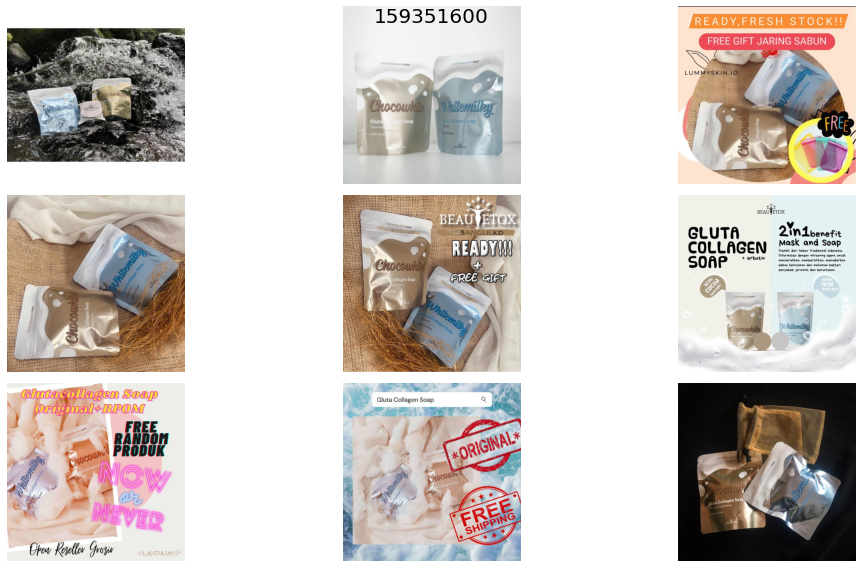

In [7]:
lg = 159351600
display_multiple_img(group_path(lg,'l'), 3, 3,lg)

# object detection

In [9]:

!pip install opencv-contrib-python

import cv2
%matplotlib inline

In [10]:
tmp_paths = train_df['image'][train_df['label_group']==lg].values

img_title = "Monde Boromon Cookies 1 tahun+ 120gr"
tmp_paths =  train_df['image'][train_df['title']==img_title].values

# akaze

In [11]:
def iou(a: tuple, b: tuple) -> float:
    a_x1, a_y1, a_x2, a_y2 = a
    b_x1, b_y1, b_x2, b_y2 = b
    
    if a == b:
        return 1.0
    elif (
        (a_x1 <= b_x1 and a_x2 > b_x1) or (a_x1 >= b_x1 and b_x2 > a_x1)
    ) and (
        (a_y1 <= b_y1 and a_y2 > b_y1) or (a_y1 >= b_y1 and b_y2 > a_y1)
    ):
        intersection = (min(a_x2, b_x2) - max(a_x1, b_x1)) * (min(a_y2, b_y2) - max(a_y1, b_y1))
        union = (a_x2 - a_x1) * (a_y2 - a_y1) + (b_x2 - b_x1) * (b_y2 - b_y1) - intersection
        return intersection / union
    else:
        return 0.0

def nmw(bboxes: list, scores: list, iou_threshold: float) -> list:
    new_bboxes = []
    
    while len(bboxes) > 0:
        i = scores.index(max(scores))
        bbox = bboxes.pop(i)
        score = scores.pop(i)
        
        numerator = (bbox[0] * score, bbox[1] * score, bbox[2] * score, bbox[3] * score)
        denominator = score
        deletes = []
        for j, (bbox_j, score_j) in enumerate(zip(bboxes, scores)):
            iou_j = iou(bbox, bbox_j)
            if iou_j > iou_threshold:
                w = scores[j] * iou_j
                numerator = (
                    numerator[0] + bbox_j[0] * w, numerator[1] + bbox_j[1] * w,
                    numerator[2] + bbox_j[2] * w, numerator[3] + bbox_j[3] * w
                )
                denominator += w
                
                deletes.append(j)
                
        for j in deletes[::-1]:
            bboxes.pop(j)
            scores.pop(j)
          
        new_bboxes.append((
            numerator[0] / denominator, numerator[1] / denominator,
            numerator[2] / denominator, numerator[3] / denominator
        ))
        
    return new_bboxes

def wbf(bboxes: list, scores: list, iou_threshold: float, n: int) -> (list, list):
    lists, fusions, confidences = [], [], []
    
    indexes = sorted(range(len(bboxes)), key=scores.__getitem__)[::-1]
    for i in indexes:
        new_fusion = True
        
        for j in range(len(fusions)):
            if iou(bboxes[i], fusions[j]) > iou_threshold:
                lists[j].append(bboxes[i])
                confidences[j].append(scores[i])
                fusions[j] = (
                    sum([l[0] * c for l, c in zip(lists[j], confidences[j])]) / sum(confidences[j]),
                    sum([l[1] * c for l, c in zip(lists[j], confidences[j])]) / sum(confidences[j]),
                    sum([l[2] * c for l, c in zip(lists[j], confidences[j])]) / sum(confidences[j]),
                    sum([l[3] * c for l, c in zip(lists[j], confidences[j])]) / sum(confidences[j]),
                )
                
                new_fusion = False
                break

        if new_fusion:
            lists.append([bboxes[i]])
            confidences.append([scores[i]])
            fusions.append(bboxes[i])
            
    confidences = [(sum(c) / len(c)) * (min(n, len(c)) / n) for c in confidences]
    
    return fusions, confidences

In [19]:
%%time

def cal_bbox_by_akaze(img1_path, img2_path, ratio = 0.60, min_size_rate = 0.03, is_plot = False):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    akaze = cv2.AKAZE_create()                
    ## Find keypoints and descriptors.
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)
    # Brute-Force Matcher生成
    bf = cv2.BFMatcher()
    # 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
    matches = bf.knnMatch(des1, des2, k=2)
    ## Appy ratio test.
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    n = len(good)
    return n
    """
    if n >= 3: # 成功
        kp1_x = []
        kp1_y = []
        kp2_x = []
        kp2_y = []
        for i in range(n):
            gq = good[i][0].queryIdx
            gt = good[i][0].trainIdx
            kp1_x.append(kp1[gq].pt[0])
            kp1_y.append(kp1[gq].pt[1])
            kp2_x.append(kp2[gt].pt[0])
            kp2_y.append(kp2[gt].pt[1])
        img1_bbox = (int(min(kp1_x)),int(min(kp1_y)), int(max(kp1_x)), int(max(kp1_y)))
        img2_bbox =  (int(min(kp2_x)),int(min(kp2_y)), int(max(kp2_x)), int(max(kp2_y)))

        # 小さすぎるものは取り除く
        if abs(img1_bbox[2]-img1_bbox[0]) * abs(img1_bbox[3]-img1_bbox[1]) < min_size_rate * img1.shape[0] * img1.shape[1]:
            img1_bbox = None
        if abs(img2_bbox[2]-img2_bbox[0]) * abs(img2_bbox[3]-img2_bbox[1]) < min_size_rate * img2.shape[0] * img2.shape[1]:
            img2_bbox = None

        
    else: # 失敗
        #print("cannot find matches")
        img1_bbox = None
        img2_bbox = None

    if is_plot:
        figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        # bbox を書き込み
        if (img1_bbox is not None) and (img2_bbox is not None):
            cv2.rectangle(img1, (img1_bbox[0], img1_bbox[1]), (img1_bbox[2], img1_bbox[3]), (0, 255, 0), 2)
            cv2.rectangle(img2, (img2_bbox[0], img2_bbox[1]), (img2_bbox[2], img2_bbox[3]), (0, 255, 0), 2)
        # 対応する特徴点同士を描画
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
        # 画像表示
        ax.ravel()[0].imshow(img1)
        ax.ravel()[1].imshow(img2)
        ax.ravel()[2].imshow(img3)

    return img1_bbox, img2_bbox"""


for i in range(1000):
    cal_bbox_by_akaze(os.path.join(train_jpg_directory, tmp_paths[3]), os.path.join(train_jpg_directory, tmp_paths[4]), is_plot=True)
    

CPU times: user 4min 35s, sys: 2.36 s, total: 4min 37s
Wall time: 2min 37s


In [ ]:
%%time
def all_pair_bbox(paths, is_plot=False):
    img_num = len(paths)
    bbox_dic = {}
    for path in paths:
        bbox_dic[path] = []
    for i in range(img_num):
        for j in range(i+1,img_num):
            bbox_i, bbox_j = cal_bbox_by_akaze(paths[i], paths[j], ratio = 0.60, min_size_rate = 0.04)
            if (bbox_i is not None) and (bbox_j is not None):
                bbox_dic[paths[i]].append(bbox_i)
                bbox_dic[paths[j]].append(bbox_j)

    # box をマージ  NMW
    for path in paths:
        if len(bbox_dic[path]) > 1:
            bbox_dic[path] = nmw(bbox_dic[path], [1. for i in range(len(bbox_dic[path]))], 0.3)
            #bbox_dic[path], _ = wbf(bbox_dic[path], [1. for i in range(len(bbox_dic[path]))], 0.4, (img_num*(img_num-1)/2)//2 + 1)
            
    if is_plot:
        print(f"len: {img_num}")
        plot_num = img_num
        figure, ax = plt.subplots(nrows=((plot_num+2)//3), ncols=3, figsize=(16,4*((plot_num+2)//3)))
        for i in range(plot_num):
            img1 = cv2.imread(paths[i])
            img1_bboxs = bbox_dic[paths[i]]
            # bbox を書き込み
            if len(img1_bboxs)>0:
                for img1_bbox in img1_bboxs:
                    cv2.rectangle(img1, (int(img1_bbox[0]), int(img1_bbox[1])), (int(img1_bbox[2]), int(img1_bbox[3])), (0, 255, 0), 2)
                # 画像表示
            ax.ravel()[i].imshow(img1)
    return bbox_dic

"""
1733221456	46	46	46	46
1166650192	46	46	46	46
3206118280	49	49	49	49
1141798720	51	51	51	51
1163569239	51	51	51	51
994676122	51	51	51	51
3113678103	51	51	51	51
562358068	51	51	51	51
3627744656	51	51	51	51
159351600	51	51	51	51
"""
tmp_paths = train_df['image'][train_df['label_group']==1166650192].values[:9]
#img_title = "Monde Boromon Cookies 1 tahun+ 120gr"
#tmp_paths =  train_df['image'][train_df['title']==img_title].values
dic = all_pair_bbox(train_jpg_directory + tmp_paths, is_plot=True)

# 角度を考える

特徴点のマッチングを考えて、相対角度

In [ ]:
# https://qiita.com/grouse324/items/74988134a9073568b32d

import math

def get_most_likely_matches(kp1, kp2, good):
    point_num = len(good)
    if point_num >= 3: # 成功
        kp1_x = []
        kp1_y = []
        kp2_x = []
        kp2_y = []
        for i in range(point_num):
            gq = good[i][0].queryIdx
            gt = good[i][0].trainIdx
            kp1_x.append(kp1[gq].pt[0])
            kp1_y.append(kp1[gq].pt[1])
            kp2_x.append(kp2[gt].pt[0])
            kp2_y.append(kp2[gt].pt[1])
    # 点i, jの相対角度と相対長さを格納する配列
    deg_cand = np.zeros((point_num, point_num))  
    len_cand = np.zeros((point_num, point_num))
    # 全ての点のサイズ比，相対角度を求める
    for i in range(point_num):
        for j in range(i+1, point_num):
            # クエリ画像から特徴点間の角度と距離を計算
            q_x1, q_y1 = kp1_x[i], kp1_y[i]
            q_x2, q_y2 = kp1_x[j], kp1_y[j]
            q_deg = math.atan2(q_y2 - q_y1, q_x2 - q_x1) * 180 / math.pi
            q_len = math.sqrt((q_x2 - q_x1) ** 2 + (q_y2 - q_y1) ** 2)
            # マップ画像から特徴点間の角度と距離を計算
            m_x1, m_y1 = kp2_x[i], kp2_y[i]
            m_x2, m_y2 = kp2_x[j], kp2_y[j]
            m_deg = math.atan2(m_y2 - m_y1, m_x2 - m_x1) * 180 / math.pi
            m_len = math.sqrt((m_x2 - m_x1) ** 2 + (m_y2 - m_y1) ** 2)
            # 2つの画像の相対角度と距離
            deg_value = q_deg - m_deg
            if deg_value < 0:
                deg_value += 360
            if m_len <= 0:
                continue
            size_rate = q_len/m_len
            deg_cand[i][j] = deg_value
            deg_cand[j][i] = deg_value
            len_cand[i][j] = size_rate
            len_cand[j][i] = size_rate
    # 多数決を取る
    # ある点iについて，j, kとの相対関係が一致するかを各jについて調べる
    cand_count = np.zeros((point_num, point_num))
    size_range_min = 0.3  # 明らかに違う比率の結果を弾く重要パラメータ
    size_range_max = 3  # 明らかに違う比率の結果を弾く重要パラメータ
    dif_range = 0.04  # 重要パラメータ
    for i in range(len(deg_cand)):
        for j in range(len(deg_cand)):
            # 明らかに違う比率の結果を弾く
            if len_cand[i][j] < size_range_min or len_cand[i][j] > size_range_max:
                continue
            for k in range(len(deg_cand)):
                # 明らかに違う比率の結果を弾く
                if len_cand[i][k] < size_range_min or len_cand[i][k] > size_range_max:
                    continue
                # 誤差がある範囲以下の値なら同じ値とみなす
                deg_dif = np.abs(deg_cand[i][k] - deg_cand[i][j])
                size_dif = np.abs(len_cand[i][k] - len_cand[i][j])
                if deg_dif <= deg_cand[i][j]*dif_range and size_dif <= len_cand[i][j]*dif_range:
                    cand_count[i][j] += 1
    # print(cand_count)
    # どの2点も同じ相対関係になかった場合
    if np.max(cand_count) <= 1:
        print("[error] no matching point pair")
        return []
    # もっとも多く相対関係が一致する2点を取ってくる
    maxidx = np.unravel_index(np.argmax(cand_count), cand_count.shape)
    deg_value = deg_cand[maxidx]
    size_rate = len_cand[maxidx]

    new_good_ids = []
    for i in range(len(deg_cand)):
        for j in range(len(deg_cand)):
            # 誤差がある範囲以下の値なら同じ値とみなす
            deg_dif = np.abs(deg_cand[i][j] - deg_value)
            size_dif = np.abs(len_cand[i][j] - size_rate)
            if deg_dif <= deg_cand[i][j]*dif_range and size_dif <= len_cand[i][j]*dif_range:
                new_good_ids.append(i)
                new_good_ids.append(j)
    new_good_ids = set(new_good_ids)
    print(len(new_good_ids))
    new_good = [good[i] for i in new_good_ids]
    return new_good



def cal_bbox_by_akaze(img1_path, img2_path, ratio = 0.60, min_size_rate = 0.03, is_plot = False):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    akaze = cv2.AKAZE_create()                
    ## Find keypoints and descriptors.
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)
    # Brute-Force Matcher生成
    bf = cv2.BFMatcher()
    # 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
    matches = bf.knnMatch(des1, des2, k=2)
    ## Appy ratio test.
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    good = get_most_likely_matches(kp1, kp2, good)
    n = len(good)
    if n >= 3: # 成功
        kp1_x = []
        kp1_y = []
        kp2_x = []
        kp2_y = []
        for i in range(n):
            gq = good[i][0].queryIdx
            gt = good[i][0].trainIdx
            kp1_x.append(kp1[gq].pt[0])
            kp1_y.append(kp1[gq].pt[1])
            kp2_x.append(kp2[gt].pt[0])
            kp2_y.append(kp2[gt].pt[1])
        img1_bbox = (int(min(kp1_x)),int(min(kp1_y)), int(max(kp1_x)), int(max(kp1_y)))
        img2_bbox =  (int(min(kp2_x)),int(min(kp2_y)), int(max(kp2_x)), int(max(kp2_y)))

        # 小さすぎるものは取り除く
        if abs(img1_bbox[2]-img1_bbox[0]) * abs(img1_bbox[3]-img1_bbox[1]) < min_size_rate * img1.shape[0] * img1.shape[1]:
            img1_bbox = None
        if abs(img2_bbox[2]-img2_bbox[0]) * abs(img2_bbox[3]-img2_bbox[1]) < min_size_rate * img2.shape[0] * img2.shape[1]:
            img2_bbox = None

        
    else: # 失敗
        #print("cannot find matches")
        img1_bbox = None
        img2_bbox = None

    if is_plot:
        figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        # bbox を書き込み
        if (img1_bbox is not None):
            cv2.rectangle(img1, (img1_bbox[0], img1_bbox[1]), (img1_bbox[2], img1_bbox[3]), (0, 255, 0), 2)
        if (img2_bbox is not None):
            cv2.rectangle(img2, (img2_bbox[0], img2_bbox[1]), (img2_bbox[2], img2_bbox[3]), (0, 255, 0), 2)
        # 対応する特徴点同士を描画
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
        # 画像表示
        ax.ravel()[0].imshow(img1)
        ax.ravel()[1].imshow(img2)
        ax.ravel()[2].imshow(img3)
    return img1_bbox, img2_bbox

img1_bbox, img2_bbox = cal_bbox_by_akaze(os.path.join(train_jpg_directory, tmp_paths[2]), os.path.join(train_jpg_directory, tmp_paths[0]), is_plot=True)
print(img1_bbox, img2_bbox)